### Algoritmos Genéticos

Para los ejemplos utilizaremos el problema del viajante de comercio (TSP)

In [1]:
# definición del TSP

import random
N = 10

cities = []

for i in range(N):
	c = [random.random(), random.random()]
	cities.append(c)

#print(cities)

cities = [[0.8744058793117488, 0.30207179832703746], [0.6901572276474558, 0.8203362566663311], [0.7793458478083026, 0.09728979746351918], [0.7483358474304422, 0.4563419482458657], [0.4556164527790729, 0.12863149772605698], [0.1837236688553453, 0.23773749495644914], [0.806151832654163, 0.3288366900529254], [0.6222702185205219, 0.6019431085670109], [0.21886861543988367, 0.6980104036528004], [0.9706096813038716, 0.054871876245520146], [0.13881496219356027, 0.048489530185603646], [0.08511086492841424, 0.9123075505436051], [0.45436952164297595, 0.4731540740573398], [0.8986352255038935, 0.5116579750591849], [0.9539248970461742, 0.7530784036308166], [0.6321102985156373, 0.13575967095580344], [0.31130918313591205, 0.8545457319320597], [0.025897479791937017, 0.7854526665590987], [0.31414095045738066, 0.051421702103483846], [0.2739561013272712, 0.1970964027924862], [0.22762328443470214, 0.627414210742153], [0.44920042912037383, 0.18835427573438068], [0.2793138301174244, 0.9103956650199608], [0.005128451667189338, 0.4655718085045638], [0.9222718335261915, 0.8613103704784812], [0.49352498279326595, 0.28652416807644077], [0.5560886356057152, 0.034564925228364185], [0.0048939219846825255, 0.8635350555457212], [0.7824462381771976, 0.09355415747424733], [0.2973635133076785, 0.037580527218207815], [0.659068210692151, 0.5602321147981546], [0.43549418718677035, 0.6241289474799954], [0.25580657871099755, 0.519726015381631], [0.5950780852425872, 0.3193476592023645], [0.15763623266223903, 0.18210618406479095], [0.3434173147566393, 0.32992255868483356], [0.06451313705472006, 0.12606114349173192], [0.23212286400737547, 0.3945559700824013], [0.955507285594692, 0.02296933408938162], [0.7459955912073274, 0.1385374827130177], [0.46365765315595475, 0.6132297411379687], [0.20196772698059162, 0.046358747430397584], [0.2980093518214506, 0.36041197123227897], [0.7533459401199348, 0.6610562232191091], [0.323433933838161, 0.5068337090138902], [0.062138830138457, 0.7177455044259695], [0.47467832142010535, 0.17692718986260936], [0.2415634321550142, 0.500852093941769], [0.3441878827094532, 0.2604351258948506], [0.5445252142594251, 0.7295590645635646], [0.25391391610860914, 0.7641244059389684], [0.2630560480211699, 0.010670642241309536], [0.2092202940037915, 0.7415775443241935], [0.0031474687633804566, 0.6974574785842637], [0.4952329615559806, 0.9311775894780175], [0.1978488658972426, 0.8872693649066419], [0.1705364411799497, 0.8846808176103278], [0.7634962513234275, 0.4358457309207533], [0.9259752834140167, 0.0056226911773098465], [0.22090405091557253, 0.14500040130773872], [0.4636205151855679, 0.19249574424477278], [0.8057632881682811, 0.250168118157608], [0.6785236695642043, 0.39119477830554505], [0.4837264739606879, 0.23045417711558214], [0.8786721718893166, 0.015853186240832207], [0.1263309724872509, 0.9185321014517236], [0.24969404380600335, 0.9600467657522086], [0.5886119367943214, 0.10948123668473264], [0.13373527735293878, 0.5336853876899833], [0.5642696742735989, 0.9801384844337597], [0.646401605512568, 0.3338636388089157], [0.05603526365085032, 0.3149530712641142], [0.387141492676661, 0.5792852545912592], [0.8634070619751958, 0.8206820685065667], [0.4662474858565825, 0.32647667516764145], [0.01801973379815025, 0.12175434785651695], [0.6218125565554127, 0.07860046445444713], [0.6573938922925594, 0.5023092428939168], [0.2837581848186974, 0.02576704782244421], [0.3044774374252185, 0.7310313422019327], [0.33131673439274434, 0.693896434962478], [0.8523694048117944, 0.2805224723356823], [0.6200019812032047, 0.03989814578273998], [0.5437394088109648, 0.3258031129949792], [0.4386079860370994, 0.6142798815693052], [0.7430581106897977, 0.49260737229959284], [0.3913628378102181, 0.3185830750836698], [0.9065498976196814, 0.02381958527497441], [0.6874236611131453, 0.18642068590773597], [0.6946411585627993, 0.36991609629423117], [0.3784063098306413, 0.01018756575849844], [0.43806374889930155, 0.2268325586117821], [0.7411632641820634, 0.35513151640087337], [0.3884706603234591, 0.34043302784114093], [0.08674110453583683, 0.4491174987265194], [0.9794883193315694, 0.11207520940235804], [0.7496156619797683, 0.23845386610980834], [0.4423888847621813, 0.17212722421686055], [0.2276570035864689, 0.6515924491551327], [0.836939257954547, 0.0499933914625984]] # Length=8.587

def dist (x, y): # distancia euclídea
	return ( (x[0]-y[0])**2 + (x[1]-y[1])**2 ) ** 0.5

def globaldist (cities): # calcula la ditancia global de una solución
	acum = 0.0
	for i in range(len(cities)):
		acum += dist(cities[i-1],cities[i]) # -1 is the last element
	return acum

def nearest (c, l): # get the nearest city to c in l
	res = l[0]
	d = dist(c,l[0])
	for e in l[1:]:
		newd = dist(c,e)
		if newd < d:
			res = e
			d = newd
	return res

In [2]:
# draw a TSP solution

import matplotlib.pyplot as plt
import numpy as np

def draw (solution):
    plt.ion()
    fig = plt.figure()
    axes = fig.add_subplot(111)
    #xlim = axes.set_xlim(0.0,1.0)
    #ylim = axes.set_ylim(0.0,1.0)
    x = []
    y = []

    bucle = solution + [solution[0]] # añade al final la vuelta a la primera

    c = np.array(bucle)
    x = c[:,0]
    y = c[:,1]

    l1, = axes.plot(x, y,'g')
    pl2, = axes.plot(x, y,'ro')
    
    s = 'Length=%5.3f' % globaldist(bucle)
    plt.title(s)

In [3]:
# Poblaciones de la Comunidad de Madrid

from madrid import *

def dist (x, y):
	return ( ( (x[0]-y[0])**2 + (x[1]-y[1])**2 ) ** 0.5 ) * 111.1 # km por grado

def draw (solution):
    minx, maxx = -4.79, -2.82
    miny, maxy = 39.92, 41.16
    margx = 0.05
    margy = 0.1

    plt.ion()
    fig = plt.figure()
    axes = fig.add_subplot(111)
    axes.set_xlabel('lon')
    axes.set_ylabel('lat')
    xlim = axes.set_xlim(minx, maxx)
    ylim = axes.set_ylim(miny, maxy)
    img = plt.imread("madrid.jpg")
    plt.imshow(img, extent=[minx-margx,maxx+margx,miny-margy,maxy+margy], aspect='auto')

    bucle = solution + [solution[0]] # añade al final la vuelta a la primera
    c = np.array(bucle)
    x = c[:,1]
    y = c[:,0]

    l1, = axes.plot(x, y,'r')
    pl2, = axes.plot(x, y,'bo',markersize=2)
    
    s = 'Length=%5.3f' % globaldist(bucle)
    plt.title(s)

### Algoritmos Genéticos

Haremos una implementación funcional, aunque sería más apropiado definir una clase

In [5]:
import random

class AG:
    def __init__ (self, alphabet, fitness_func, L, pcross, pmut, T):
        # inicializa atributos de clase (puedes añadir más cosas)
        self.alphabet = alphabet # alfabeto a utilizar
        self.finess_func = fitness_func # función de fitness
        self.L = L # en permutación debe ser igual a len(alphabet)
        self.pcross = pcross # probabilidad de cruce
        self.pmut = pmut # probabilidad de mutación
        self.T = T # parámetro T para selección por torneo

    def sort_pop (self): # ordena población por firness (reverse=True si queremos maximizar)
        pass # TO-DO

    def select (self): # devuelve un individuo seleccionado por torneo, devuelve una copia para evitar efectos laterales
        # saca T indices y se queda con el más bajo (al estar ordenados el más bajo será el mejor)
        pass # TO-DO

    def evolve (self, pop, ngen=100, trace=0, elitism=False):
        N = len(pop)
        L = len(pop[0])
        best = pop[0]
        for i in range(ngen): # para cada generación
            newpop = []
            f, pop = self.sort_pop(pop, self.finess_func) # ordena por fitness
            best = pop[0]
            bestf = f[0]
            if elitism: # mantiene los dos mejores
                newpop.append(pop[0])
                newpop.append(pop[1])
            while len(newpop) < N:
                i1 = self.select()
                i2 = self.select()
                i1, i2 = self.crossover(i1, i2)
                i1 = self.mutate(i1)
                i2 = self.mutate(i2)
                newpop.append(i1)
                newpop.append(i2)
            pop = newpop
            if trace != 0:
                if i%trace == 0:
                    print(f"{bestf:.4f}")
        print(f"\nFitness óptimo: {bestf:.3f}")
        print("Mejor individuo", best)
        f, pop = self.sort_pop(pop, self.finess_func, False)
        return pop

In [9]:
class AG_perm (AG):
    def create (self, N=100):
        pass # TO-DO

    def crossover (self, ind1, ind2): # order crossover (OX1)
        pass # TO-DO

    def mutate (self, ind): # la mutación consistirá en intercambiar elementos
        pass # TO-DO

In [ ]:
### ejemplo: el mejor individuo es el que tiene todos los genes = 0

def fit (ch):
    res = 0
    for e in ch:
        res += e
    return res

g = GA(list(range(10)), fit, 0.1, L=10, T=4, elitism=True)
g.create()
g.evolve(1000)

### Vamos con el TSP

Creamos la población

In [ ]:
def fitness_TSP (ind):
    return 1 / (1 + globaldist(ind))

g = AG_perm(cities, fitness_TSP, 0.7, 0.01, L=len(cities), T=2)
pop = g.create(cities)

### Evolucionamos y pintamos resultados

In [ ]:
pop = g.evolve(pop, ngen=1000, trace=100)
draw(pop[0])

Si no llega a una solución suficientemente buena. Puede ser por varios motivos:
  * Pocas generaciones. Continuar a ver.
  * pmut incorrecta: demasiado baja: convergencia muy lenta; demasiado alta: mucha aleatoriedad, la optimización no pregresa debido al ruido.
  * T incorrecto: demasiado bajo, pocas opciones a los mejores; demasiado alto: se cae en minimo local.
  * El mejor individuo se pierde: probar elitismo.
  * Hemos caído en un mínimo local: volver a empezar (multiarranque).
  * Hay otras estrategias de mutación mejores para este problema, mejorar la implementación.

1265.4403 1264.5668 1264.5668 1264.5668 1264.5668 1264.5668 1264.5668 1264.5668 1264.5668 1264.5668 1264.5668 1264.5668 1264.5668 1257.1743 1257.1743 1257.1743 1247.5130 1247.5130 1247.2510 1247.2510 
Fitness óptimo: 1247.251
Mejor individuo [[40.54481, -3.457924], [40.53437, -3.481002], [40.50481, -3.53227], [40.54751, -3.626394], [40.54754, -3.642091], [40.42594, -3.565464], [40.42553, -3.536694], [40.39701, -3.487864], [40.4589, -3.479771], [40.48166, -3.364136], [40.54861, -3.377597], [40.59229, -3.41205], [40.6665, -3.392131], [40.63099, -3.332983], [40.5542, -3.328439], [40.50191, -3.254799], [40.47216, -3.233114], [40.46549, -3.268585], [40.43228, -3.298869], [40.36622, -3.321994], [40.33815, -3.380982], [40.38393, -3.409393], [40.40473, -3.360132], [40.41972, -3.298921], [40.42489, -3.262723], [40.41869, -3.177605], [40.3292, -3.181895], [40.36943, -3.221704], [40.36552, -3.243183], [40.33669, -3.235551], [40.29548, -3.303884], [40.23453, -3.352198], [40.24457, -3.314466], [40.

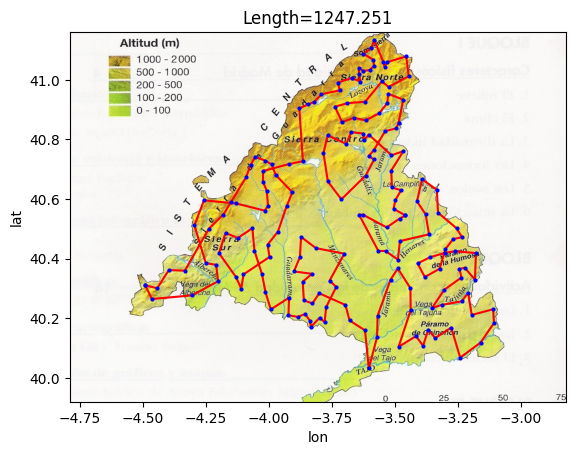

In [ ]:
# ejemplo; debes superar al menos esta solución:
pop = g.evolve(pop, ngen=10000, trace=500, T=12)
draw(pop[0])

In [ ]:
# función himmelblau y himmelblau global

onlyone = False # poner a True para que la solución sea única
def himmelblau (ch):
	x = ch[0]
	y = ch[1]
	fxy = (x**2 + y - 11)**2 + (x + y**2 -7)**2
	if onlyone and (x>0 or y>0): # himmelblau modified to have only one global minimum (-3.77, -3.28)
		fxy += 0.5
	return fxy

### Comentarios finales sobre el TSP

  * Hay varias vecindades interesantes en https://dm865.github.io/assets/dm865-tsp-ls-handout.pdf
  * Para problemas grandes, el problema es que como mínimo son $O(n^2)$
  * El fitness se puede calcular en una búsqueda local con deltas, es decir, alterando la evaluación anterior teniendo en cuenta el cambio realizado, lo que hace la evaluación mucho más rápida. Por ejemplo, si una ciudad se intercambia por otra sólo hay que restar 4 valores y sumar otros 4, en lugar de recorrer la lista entera.
  * Según el teorema del no free lunch, esto hace nuestro algoritmo más específico del problema TSP.